# Chapter04 모델 훈련

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

### 4.1 선형 회귀

선형회귀 모델의 예측 ( $\hat{y}$ )

$\hat{y} = h_\theta(x) = \theta \space \cdot x = \theta^T \cdot x$

- $\theta$ : 가중치

- $x$ : 특성

$MSE(X, h_\theta) = \frac{1}{m} \Sigma^m_{i=1} ( \theta^T x^{(i)} - y^{(i)})^2 = \frac{1}{m} \Sigma^m_{i=1} ( X \cdot \hat{\theta} - y^{(i)})^2$

미분 계산 : $\frac{\partial L}{\partial \hat{\theta}}$ = 0 $\space$  (기울기 0)

--> $\hat{\theta} = (X^T X)^{-1} X^T y$ ( **정규 방정식** )

In [2]:
# (선형 데이터셋) 무작위로 생성
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # y = 3x + 4 + (가우시안 잡음)

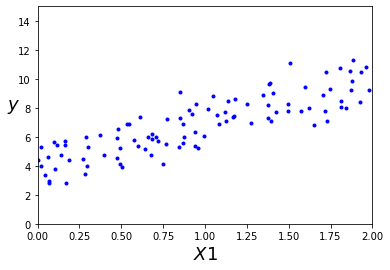

In [3]:
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.xlabel('$X1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.show()

위 정규방정식을 사용하여 $\hat{\theta}$ 를 구해보자

In [4]:
X_b = np.c_[np.ones((100, 1)), X]   # X에 편향계수 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  # 정규 방정식
theta_best

array([[4.03384709],
       [2.94711943]])

In [5]:
# theta_best로 예측하기
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]  # 펀향 계수 추가
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.03384709],
       [9.92808595]])

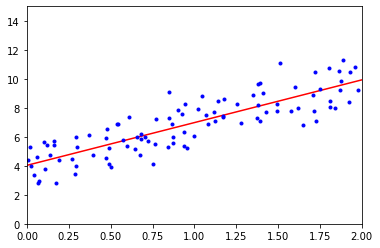

In [6]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# 사이킷런에서의 선형 회귀 수행
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)
lin_reg.predict(X_new)

[4.03384709] [[2.94711943]]


array([[4.03384709],
       [9.92808595]])

In [8]:
# LinearRegression()은 np.linalg.lstsq이 기반이 된다

# residuals: 실제데이터와의 차이
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)   # Least Square
print(theta_best_svd)
print(f'residuals: {residuals}')

[[4.03384709]
 [2.94711943]]
residuals: [112.61264915]


In [9]:
np.linalg.pinv(X_b).dot(y)  # 유사 역행렬 (pseudo inverse)

array([[4.03384709],
       [2.94711943]])

유사역행렬은 **SVD 분해** 기법을 사용하여 계산된다.

- 정규방정식은 $X^T X$ 의 역행렬이 없으면 작동하지 않지만, 유사역행렬은 항상 구할 수 있다.

- SVD 방법의 계산복잡도는 정규방정식보다 4배 가량 더 빠르다.

---

### 4.2 경사 하강법

GD : 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것

- 경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다. (특성 스케일링)

$$\theta^{(next \space step)_i} = \theta_{(i)} - \eta \frac{\partial L}{\partial \theta_{(i)}}$$

- 배치 경사 하강법 (BGD)

In [10]:
# 배치 경사하강법 구현

eta = 0.1   # 학습률
n_iterations = 1000  # 반복 수
m = 100     # 샘플 수

theta = np.random.randn(2,1)  # 무작위 초기화
print(f"초기 theta 값: \n{theta}\n")

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
print(f"학습 후 theta 값: \n{theta}")

초기 theta 값: 
[[ 0.34634558]
 [-0.06615615]]

학습 후 theta 값: 
[[4.03384709]
 [2.94711943]]


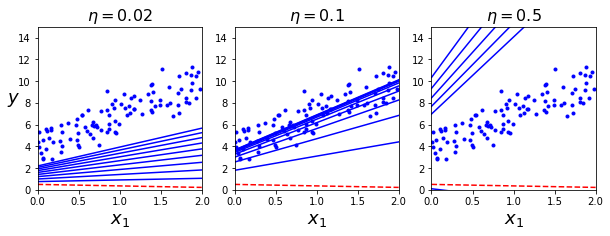

In [11]:
# 학습률에 따른 학습 상태
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,3))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

적절한 학습률을 적용해주어야 학습이 잘된다. --> 그리드 탐색으로 최적의 학습률 찾기

- 확률적 경사 하강법 (SGD)

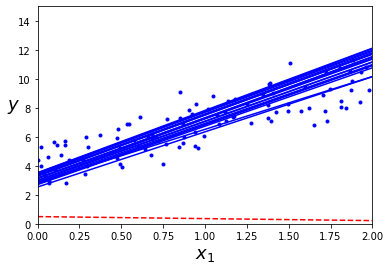

In [12]:
# SGD 구현

theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50   # 에포크
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터
# 학습 스케줄: 매 반복에서 학습률을 결정하는 함수

def learning_schedule(t):   # 학습률을 점진적으로 감소시키는 학습 스케줄
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 무작위로 초기화

for epoch in range(n_epochs):   # 에포크만큼 반복
    for i in range(m):          # 훈련 샘플 수 만큼 반복

        # 첫 에포크일때 스텝 그리기
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)  
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)

        random_index = np.random.randint(m)     # 랜덤으로
        xi = X_b[random_index:random_index+1]   # 하나씩만 따로 훈련
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

        theta_path_sgd.append(theta)      

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])                   
plt.show()     

In [13]:
from sklearn.linear_model import SGDRegressor

# max_iter: 에포크 횟수
# tol: 한 에포크에서 tol 보다 적게 손실이 줄어들 때까지 실행된다는 의미
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())   # ravel() == flatten()

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [14]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.0087221]), array([2.93484772]))

- 미니배치 경사 하강법 (MGD = BGD + SGD)

In [15]:
# 미니배치 경사하강법 구현

theta_path_mgd = []

n_iterations = 50    # 에포크
minibatch_size = 20  # 미니배치 크기

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]   # 미니배치로 사이즈로 묶어서 학습
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta

array([[4.00051759],
       [2.88491918]])

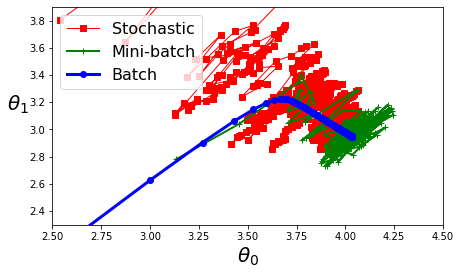

In [16]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

- 미니배치의 크기를 크게 하면 : SGD보다 덜 불규칙적으로 움직이나 local minimum에 빠질 확률이 조금 높아짐

---

### 4.3 다항 회귀

(각 특성의 거듭제곱이라던지) 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 것

간단한 2차방정식으로 비선형 데이터를 만들어보자

: $y = 0.5x_1^2 + 1.0x_1 + 2.0$

In [35]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X **2 + X + 2 + np.random.randn(m, 1)

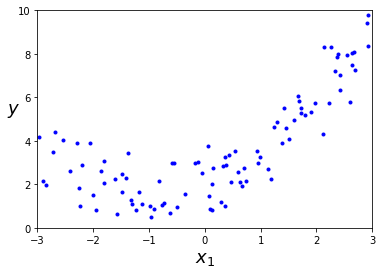

In [18]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [19]:
# 각 특성을 제곱하여 새로운 특성 추가
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([2.38942838]), array([2.38942838, 5.709368  ]))

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

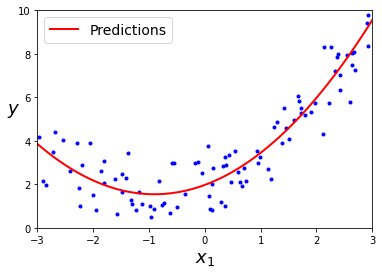

In [21]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

### 4.4 학습 곡선

In [22]:
# 훈련세트의 크기에 따른 학습 곡선

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)  # 검증세트 떼어내기
    train_errors, val_errors = [], []  # 그래프를 그려주기 위한 각 저장공간
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])   # 훈련세트의 크기를 점점 늘려가면서 훈련
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))   # 훈련세트 MSE
        val_errors.append(mean_squared_error(y_val, y_val_predict))             # 검증세트 MSE

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)             

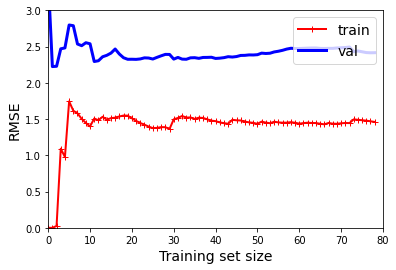

In [23]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])            
plt.show()  

과소적합의 전형적인 모습이다.

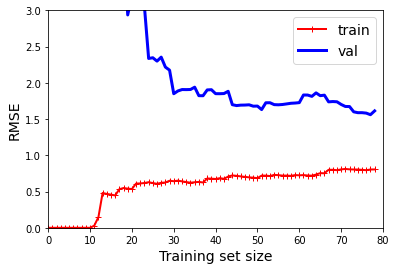

In [24]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
        ('lin_reg', LinearRegression())
    ])
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과대적합 모델의 모습

더 많은 훈련 데이터를 추가하는 것이 과대적합을 개선하는 방법 중 하나이다.

---

### 4.5 규제가 있는 선형 모델

과대적합을 감소시키려면 모델에 규제를 가해야 한다.

릿지 회귀 , 라쏘 회귀, 엘라스틱넷 : 규제가 추가된 선형회귀 버전, 모델의 가중치를 제한함으로써 규제를 가한다.

 [가중치 감쇠](http://blog.naver.com/angryking/221330145300)

**릿지 회귀** :
 
- 비용함수에 규제항$\space\alpha \Sigma^n_{i=1} \theta^2_i$ 이 추가된다. ( $l$2 노름 )

 --> 릿지 비용함수 : $J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\Sigma_{i=1}^n \theta_i^2$

- 훈련하는 동안 모델의 가중치가 최대한 작게 유지되도록 한다.

- 평가할 때는 규제항 없이 평가

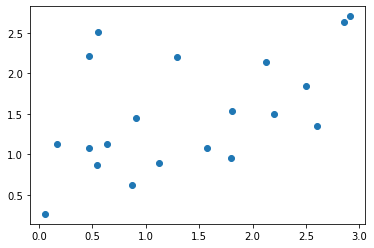

In [59]:
# 무작위 데이터 생성
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)
plt.scatter(X,y)
plt.show()

In [51]:
# 릿지 회귀
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [84]:
# Ridge 대신 SGDRegressor(penalty='l2)를 사용할 수도 있다
# SGD의 비용함수에 l2 노름 / 2 를 추가한 것
sgd_reg = SGDRegressor(penalty='l2', random_state=42)  # penalty: 규제항
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

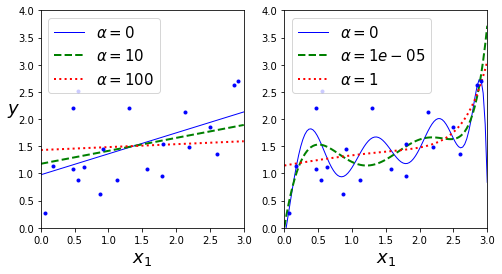

In [38]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# alpha 값에 따른 릿지모델 변화를 그려주는 메서드
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),   # 표준화
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

**라쏘 회귀 :**

- $l$1 노름 사용

- 라쏘회귀의 비용함수 : $J(\theta) = MSE(\theta) + \alpha \Sigma^n_{i=1}|\theta_i|$

- 릿지회귀에 비해 덜 중요한 특성의 가중치를 제거하려고 한다. (0으로 만듦)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


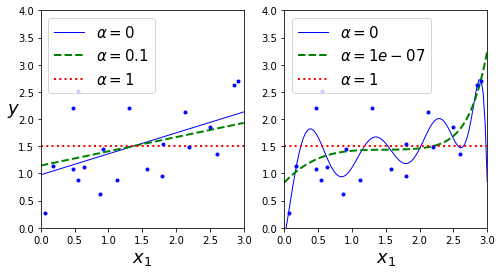

In [66]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.show()

In [70]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

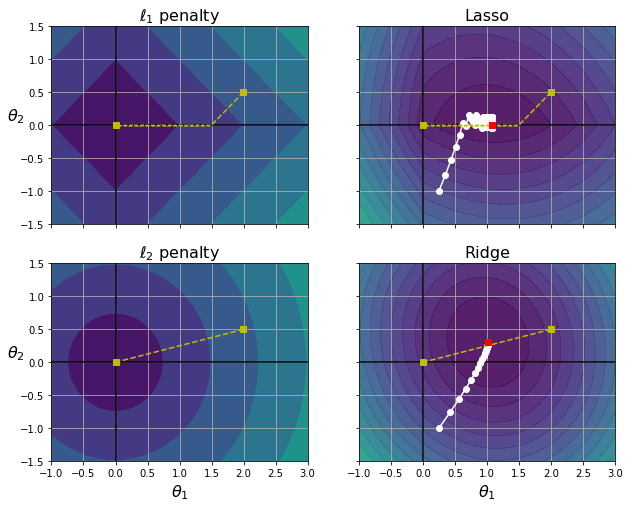

In [71]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

**엘라스틱넷** :

- 릿지 회귀와 라쏘 회귀를 절충한 모델

- $ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2} $

- $r$=0 : 릿지회귀,$\space\space$ $r$=0 : 라쏘회귀

- 릿지가 기본이 되지만, 쓰이는 특성이 몇 개뿐이라면 라쏘나 엘라스틱넷이 더 낫다.

In [88]:
# 사이킷런의 엘라스틱넷
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio: 혼합비율 r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

**조기 종료** : 검증에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

In [90]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [101]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:   # 최적의 모델 갱신
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

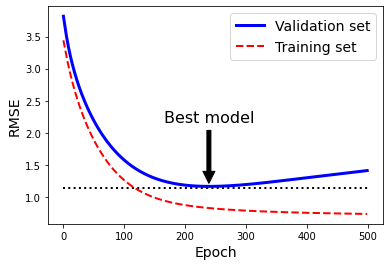

In [102]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

### 4.6 로지스틱 회귀

: 샘플이 특정 클래스에 속할 확률을 추정

로지스틱 회귀의 예측:

출력값이 결과값의 로지스틱 함수 (시그모이드 함수) :

- $\sigma(t) = \frac{1}{1+e^{-t}}\space$ --> 확률값

 - $\theta^T x$ 가 양수 --> 양성 클래스로 예측

 - $\theta^T x$ 가 음수 --> 음성 클래스로 예측

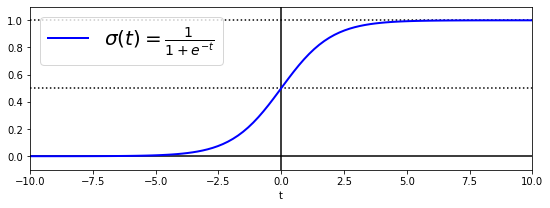

In [105]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

로지스틱 회귀의 비용함수 (로그 손실)

$ J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]} $

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


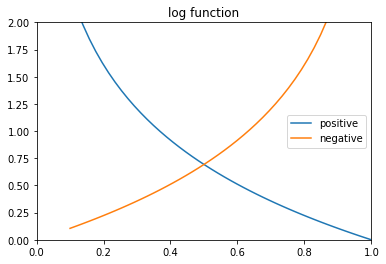

In [166]:
# 로지스틱 회귀의 비용함수
x = np.linspace(0.1, 2, 100)
plt.plot(x,-np.log(x), label='positive')
plt.plot(x, -np.log(1-x), label='negative')
plt.title('log function')
plt.axis([0,1,0,2])
plt.legend()
plt.show()

결정 경계

In [207]:
# 꽃잎의 너비를 기반으로 Iris-Virginica 종을 감지하는 이진 분류기를 만들어보자
from sklearn import datasets
iris = datasets.load_iris()
X = iris['data'][:,3:]  # 꽃잎의 너비
y = (iris['target'] == 2).astype(np.int)  # 타깃값

In [188]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

/usr/local/lib/python3.7/dist-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


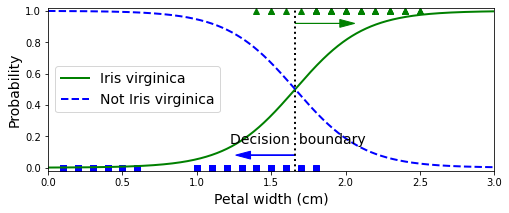

In [197]:
# 꽃잎의 너비가 0~3cm인 꽃에 대한 모델의 추정 확률

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]  # 결정 경계

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [198]:
# 샘플 예측
log_reg.predict([[1.7], [1.5]])

array([1, 0])

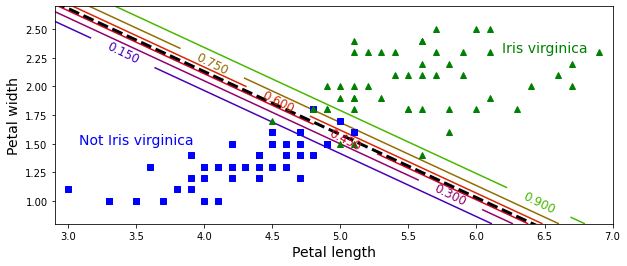

In [199]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

소프트맥스 회귀 (다항 로지스틱 회귀) : 직접 다중 클래스를 지원하도록 일반화

소프트맥스 함수 :

- $ \hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}} $

크로스 엔트로피 비용함수 :

- $ J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)} $

클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터 :

- $ \nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}} $

In [211]:
# 소프트맥스 회귀 훈련

X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

# multi_class='multinomial'으로 지정하면 소프트맥스 회귀 사용
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [212]:
# 소프트맥스 회귀 예측
softmax_reg.predict([[5, 2]])

array([2])

In [213]:
# 각 클래스에 대한 확률
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

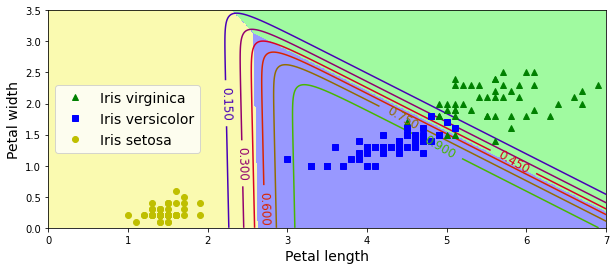

In [214]:
# 소프트맥스 회귀 결정 경계

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()